In [46]:
%matplotlib inline

In [509]:
# configure matplotlib
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from chmp.ds import reload
reload('chmp.ds')

from chmp.ds import (
    colorize,
    mpl_set,
    pd_has_ordered_assign, 
    pgm, 
    plot_gaussian_contour, 
)

In [78]:
assert pd_has_ordered_assign(), "notebook requires .assign(...) to respect argument order"

# d-seperation

Based on Daphne Koller and Nir Friedman "Probabilistic Graphical Models" (2009).

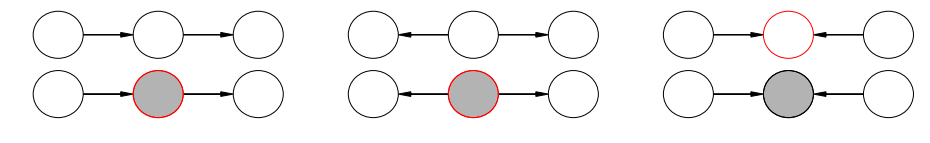

In [65]:
def _plot(edge1_lr, edge2_lr, observed, blocked):
    ec = 'r' if blocked else 'k'

    res = (
        pgm()
        .node('x', '', 1, 1)
        .node('z', '', 3, 1)
        .node('y', '', 2, 1, observed=observed, edgecolor=ec)
    )
    res = res.edge('x', 'y') if edge1_lr else res.edge('y', 'x')
    res = res.edge('y', 'z') if edge2_lr else res.edge('z', 'y')
    
    return res


_, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(16, 2))

_plot(True, True, False, False).render(ax=ax11)
_plot(True, True, True, True).render(ax=ax21)

_plot(False, True, False, False).render(ax=ax12)
_plot(False, True, True, True).render(ax=ax22)

_plot(True, False, False, True).render(ax=ax13)
_plot(True, False, True, False).render(ax=ax23)

pass

Visualize the indendence problems by approximating the mean absolute correlation (based on binning for $z$):

$$
    MAC = \frac{\sum_z |\mathrm{corr}(x, y|z)|}{\sum_z}
$$


In [133]:
def compute_macs(df, x, y, conditions):
    result = collections.OrderedDict()
    
    for condition in conditions:
        if condition:
            label = '| {}'.format(', '.join(condition))
            
        else:
            label = ''

        key = r'$\mathrm{{MAC}}({}, {}{})$'.format(x, y, label)
        mac = df.pipe(mean_absolute_correlation, x, y, condition=condition)
        result[key] = mac 
    
    return pd.Series(result)
        

def mean_absolute_correlation(df, x, y, condition=()):
    by = []
    
    for var in condition:
        by += [pd.qcut(df[var], 11)]
    
    if by:
        res = df.groupby(by)[[x, y]].corr().unstack()[x, y]
        return abs(res).mean()
    
    else:
        return abs(df[[x, y]].corr().iloc[0, 1])

In [81]:
base_graph = pgm().node('x', 1, 2).node('y', 2, 2).node('z', 1.5, 1)

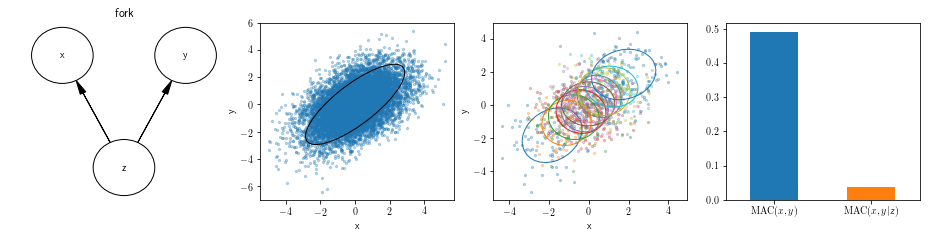

In [148]:
_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.25))

base_graph.edges('z', 'xy').render(title='fork', ax=ax1)


df = pd.DataFrame().assign(
    z=lambda df: np.random.normal(size=10_000),
    x=lambda df: np.random.normal(df["z"]),
    y=lambda df: np.random.normal(df["z"]),
)

df.plot.scatter("x", "y", marker=".", ax=ax2, alpha=0.3)
df.pipe(plot_gaussian_contour, "x", "y", ax=ax2)

for color, (_, group) in colorize(df.groupby(pd.qcut(df["z"], 11))):
    group.sample(n=100).plot.scatter("x", "y", marker=".", ax=ax3, color=color, alpha=0.3)
    group.pipe(plot_gaussian_contour, 'x', 'y', edgecolor=color, ax=ax3)

compute_macs(df, 'x', 'y', [[], ['z']]).plot.bar(ax=ax4, rot=0)
pass

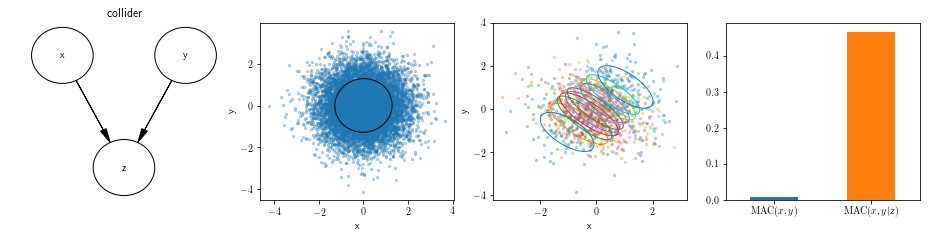

In [149]:
_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.25))

base_graph.edges('xy', 'z').render(title='collider', ax=ax1)

df = pd.DataFrame().assign(
    x=lambda df: np.random.normal(size=10_000),
    y=lambda df: np.random.normal(size=10_000),
    z=lambda df: np.random.normal(df["x"] + df["y"]),
)

df.plot.scatter("x", "y", marker=".", ax=ax2, alpha=0.3)
df.pipe(plot_gaussian_contour, "x", "y", ax=ax2)

for color, (_, group) in colorize(df.groupby(pd.qcut(df["z"], 11))):
    group.sample(n=100).plot.scatter("x", "y", marker=".", ax=ax3, color=color, alpha=0.3)
    group.pipe(plot_gaussian_contour, 'x', 'y', edgecolor=color, ax=ax3)

compute_macs(df, 'x', 'y', [[], ['z']]).plot.bar(ax=ax4, rot=0)
pass

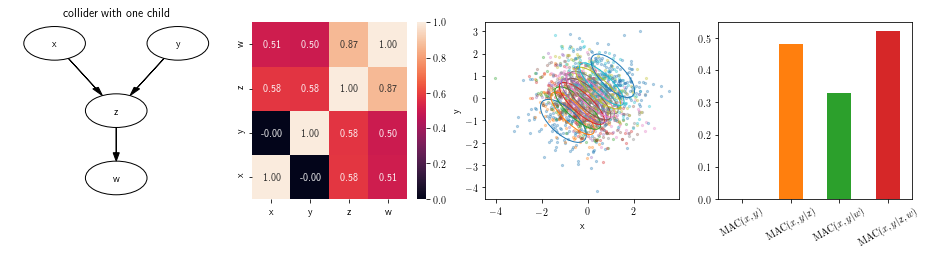

In [150]:
_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.25))

(
    pgm()
    .node('x', 1, 2)
    .node('y', 2, 2)
    .node('z', 1.5, 1)
    .node('w', 1.5, 0)
    .edge('x', 'z')
    .edge('y', 'z')
    .edge('z', 'w')
    .render(title='collider with one child', ax=ax1)
)

df = pd.DataFrame().assign(
    x=lambda df: np.random.normal(size=10_000),
    y=lambda df: np.random.normal(size=10_000),
    z=lambda df: np.random.normal(df["x"] + df["y"]),
    w=lambda df: np.random.normal(df["z"])
)

sns.heatmap(df.corr(), annot=True, fmt='.2f', ax=ax2)
mpl_set(ax=ax2, invert='y')

for color, (_, group) in colorize(df.pipe(lambda df: df.groupby(pd.qcut(df['z'], 11)))):
    group.sample(n=150).plot.scatter('x', 'y', alpha=0.3, marker='.', color=color, ax=ax3)
    group.pipe(plot_gaussian_contour, 'x', 'y', edgecolor=color, ax=ax3)

compute_macs(df, 'x', 'y', [[], ['z'], ['w'], ['z', 'w']]).plot.bar(ax=ax4, rot=30)
pass

# Causal calculus

Based on Judea Pearl "Causal diagrams for empirical research" (1995).

Define:

- $(\dots)_{\overline{X}}$: the expression $\dots$ evaluated in the graph with with all edges that point into $X$ removed
- $(\dots)_{\underline{X}}$: the expression $\dots$ evaluated in graph with all edges that point out of $X$ removed
- $\mathrm{pa}(X)$: the parents of node set $X$
- $\mathrm{an}(X)$: the ancestors of node set $X$

**Rule 1.** If removing edges into $X$, make $Y$ and $Z$ independent, then the conditional probabilities in the causal graph reflect this fact:

$$
\begin{align}
    P(Y|\mathrm{do}(X), Z, W) &= P(Y|\mathrm{do}(X), W) 
    & &\text{if $(Y \perp Z|X, W)_\overline{X}$}
\end{align}
$$


**Rule 2.** If $Z$ only acts "forward", i.e., there is no backdoor path, then conditioning and intervening have the same effect:

$$
\begin{align}
    P(Y|\mathrm{do}(X), \mathrm{do}(Z), W) &= P(Y|\mathrm{do}(X), Z, W)
    & & \text{if $(Y \perp Z|X, W)_{\overline{X}, \underline{Z}}$} 
\end{align}
$$

**Rule 3.** 

$$
\begin{align}
    P(Y|\mathrm{do}(X), \mathrm{do}(Z), W) &= P(Y|\mathrm{do}(X), W) 
    & & \text{if $(Y \perp Z|X, W)_{\overline{X}, \overline{Z - \mathrm{an}(W)}}$}
\end{align}
$$

Notable special cases:

$$
\begin{align}
    P(Y|\mathrm{do}(Z)) &= P(Y) 
    & & \text{if $(Y \perp Z)_\overline{Z}$, (III)} \\
    P(Y|\mathrm{do}(\mathrm{pa}(Y))) &= P(Y|\mathrm{pa}(Y))
    & & \text{since $(Y \perp \mathrm{pa}(Y))_\underline{\mathrm{pa}(Y)}, (II)$}
\end{align}
$$

The goal is always to remove all instances of $\mathrm{do}(\dots)$ from the expressions using aboves rules.

# Example I

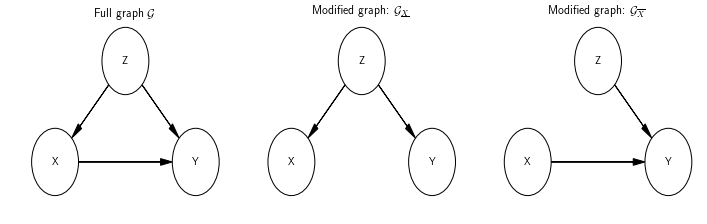

In [154]:
graph = (
    pgm()
    .node('X', 1.25, 1)
    .node('Z', 2.0, 1.75)
    .node('Y', 2.75, 1)
    .edges('Z', 'XY')
    .edges('X', 'Y')
)

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.25))
graph.render(ax=ax1, title='Full graph $\mathcal{G}$')
graph.remove(outgoing='X').render(ax=ax2, title=r'Modified graph: $\mathcal{G}_{\underline{X}}$')
graph.remove(incoming='X').render(ax=ax3, title=r'Modified graph: $\mathcal{G}_{\overline{X}}$')

$$
\begin{align}
    p(y|z, \mathrm{do}(x)) &= p(y|z, x) 
    && \text{(II), since $(Y \perp X|Z)_\underline{X}$} 
\\
    p(z|\mathrm{do}(x)) &= p(z) 
    && \text{(III), since $(Z \perp X)_\overline{X}$}
\\
    p(y|\mathrm{do}(x)) &= \sum_z p(y|z, \mathrm{do}(x)) p(z|\mathrm{do}(x)) 
    &&
\\
    &= \sum_z p(y|z, x) p(z) 
    &&
\end{align}
$$

## Example II

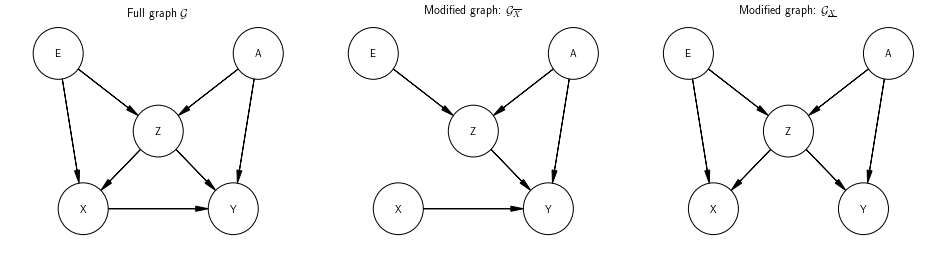

In [44]:
graph = (
    pgm()
    .node('E', 1, 2.5)
    .node('X', 1.25, 1)
    .node('Z', 2.0, 1.75)
    .node('A', 3, 2.5)
    .node('Y', 2.75, 1)
    .edges('E', 'XZ')
    .edges('Z', 'XY')
    .edges('A', 'YZ')
    .edges('X', 'Y')
)

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
graph.render(ax=ax1, title='Full graph $\mathcal{G}$')
graph.remove(incoming='X').render(ax=ax2, title=r'Modified graph: $\mathcal{G}_{\overline{X}}$')
graph.remove(outgoing='X').render(ax=ax3, title=r'Modified graph: $\mathcal{G}_{\underline{X}}$')

Application

$$
\begin{align}
    P(Y|\mathrm{do}(X)) &= \sum_{E, Z} P(Y|E, Z, \mathrm{do}(X)) P(E, Z|\mathrm{do}(X))
    &&
\\
\hline
\\
    P(E, Z|\mathrm{do}(X)) &= P(E, Z) 
    && \text{(III), since $(\{E, Z\} \perp X)_\overline{X}$}
\\
    P(Y|E, Z, \mathrm{do}(X)) &= P(Y|E, Z, X)
    && \text{(II), since $(Y \perp X|E, Z)_\underline{X}$}
\\
\hline
\\
    &= \sum_{E, Z} P(Y|E, Z, X) P(E, Z)
    &&
\\
    &= \sum_{E, Z} \frac{P(Y, E, Z, X)}{P(X|E, Z)}
\end{align}
$$

# Counterfactuals

Answers to the question: given I used $X = x$ and the path and observed $Y = y$, what whould $Y$ have been had I used $X = x^\prime$.

Can be answered by three steps (Pearl, Glymour, Jewell "Causal inference in statistics - a primer":

- **Abduciton:** determine the distribution of latents given the evedince: $P(U|E = e)$
- **Action:** modify the model, by replacing the equations for $X$ with $X = x^\prime$
- **Prediction:** use the modified model and $P(U|E=e)$ to predict the consequence of the counterfactual